In [147]:
import pandas as pd
import numpy as np
import random

In [148]:
random.seed(42)

In [149]:
from sklearn.cluster import spectral_clustering

In [150]:
from sklearn.metrics import v_measure_score

In [ ]:
data_metab = pd.read_csv('extdata/all_emci_metab.csv')
data_metab = data_metab.drop(columns=['PID','Label'])
data_metab

In [ ]:
data_actmrna = pd.read_csv('extdata/all_emci_mrna.csv')
data_actmrna = data_actmrna.drop(columns=['PID','Label'])
data_actmrna

In [153]:
data_mrna = data_actmrna

In [154]:
import snf
from snf import compute
metric = 'euclidean'
K=10
mu=0.5

affinity_networks_mrna = snf.make_affinity(data_mrna, metric=metric, K=K, mu=mu)

affinity_networks_metab = snf.make_affinity(data_metab, metric=metric, K=K, mu=mu)

affinity_networks_fused = snf.make_affinity([data_mrna, data_metab], metric=metric, K=K, mu=mu)
affinity_fused = compute.snf(affinity_networks_fused)

In [ ]:
affinity_networks_mrna.shape, affinity_networks_metab.shape, affinity_networks_fused[0].shape, affinity_networks_fused[1].shape

In [ ]:
best_mrna, second_mrna = snf.get_n_clusters(affinity_networks_mrna)
print('best_mrna', best_mrna, 'second_best_mrna', second_mrna)

best_metab, second_metab = snf.get_n_clusters(affinity_networks_metab)
print('best_metab', best_metab, 'second_best_metab' , second_metab)

best_fused, second_fused = snf.get_n_clusters(snf.snf(affinity_networks_fused, K=10, t=10, alpha=0.8))
print('best_fused', best_fused, 'second_best_fused',second_fused)


In [157]:
labels_mrna  = spectral_clustering(affinity_networks_mrna, n_clusters=2)

labels_metab = spectral_clustering(affinity_networks_metab, n_clusters=2)

labels_fused = spectral_clustering(snf.snf(affinity_networks_fused, K=10, t=20, alpha=0.8), n_clusters=2)

In [158]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [159]:
data_concat = pd.concat([data_mrna,data_metab], ignore_index=True,axis=1)

In [ ]:
affinity_fused.shape

In [ ]:
score_sil_list = []
score_chz_list = []
nmi_mrna_list  = []
nmi_metab_list = []
nmi_mrnametab_list = []

for c in range(2,11):
    data_mat = data_concat
    
    #data_mat_mrna = data_mrna
    labels_mrna  = spectral_clustering(affinity_networks_mrna, n_clusters=c)
    
    
    #data_mat = data_metab
    labels_metab  = spectral_clustering(affinity_networks_metab, n_clusters=c)
    
    
    ### fused
    
    
    print('#########################################################')
    print('# clusters #', c )
    print('SIL mrna', snf.metrics.silhouette_score(affinity_networks_mrna, labels_mrna))
    print('SIL metab', snf.metrics.silhouette_score(affinity_networks_metab, labels_metab))
    
    affinity_networks_fused = snf.make_affinity([data_mrna, data_metab], metric=metric, K=K, mu=0.3)
    affinity_fused = snf.snf(affinity_networks_fused, K=K, t=10, alpha=1.0)
    
    labels_fused = spectral_clustering(affinity_fused, n_clusters=c)
    
    print('SIL fused', snf.metrics.silhouette_score(affinity_fused, labels_fused))
    
    print('NMI fused vs mrna', v_measure_score(labels_fused, labels_mrna))
    print('NMI fused vs metab', v_measure_score(labels_fused,labels_metab  ))
    print('NMI mrna vs metab', v_measure_score(labels_mrna,labels_metab ))
    
    score_sil  = snf.metrics.silhouette_score(affinity_fused, labels_fused)

    score_chz = calinski_harabasz_score(data_mat, labels_fused)
    
    score_sil_list.append(score_sil)
    score_chz_list.append(score_chz)
    

print('SIL', [ round(item,2) for item in score_sil_list] )
print('CHZ', [ round(item,2) for item in score_chz_list])

In [ ]:
labels_fused = spectral_clustering(affinity_fused, n_clusters=2)
labels_fused

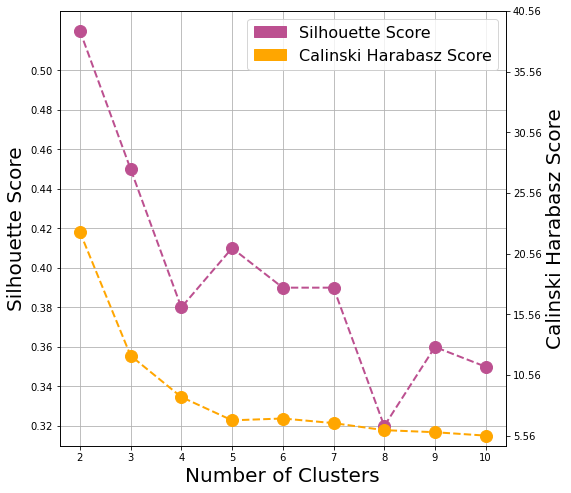

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

cps = mpatches.Patch(color='#BC5090', label='Silhouette Score')
sic = mpatches.Patch(color='#FFA600', label='Calinski Harabasz Score')
x   = [2,3,4,5,6,7,8,9,10]

y1=[0.52, 0.45, 0.38, 0.41, 0.39, 0.39, 0.32, 0.36, 0.35]

y2=[22.35, 12.15, 8.74, 6.82, 6.97, 6.59, 6.01, 5.84, 5.56]

fig, ax1 = plt.subplots(figsize=(8,8))
ax2 = ax1.twinx()
ax1.plot(x, y1, '--o', color='#BC5090', linewidth=2, markersize=12)
ax2.plot(x, y2, '--o', color='#FFA600', linewidth=2, markersize=12)

ax1.set_xlabel('Number of Clusters', fontsize = 20)
ax1.set_ylabel('Silhouette Score', color='black', fontsize = 20)
ax2.set_ylabel('Calinski Harabasz Score', color='black', fontsize = 20)
ax1.set_yticks(np.arange(min(y1), max(y1), 0.02))
ax2.set_yticks(np.arange(min(y2), max(y2)+20.0, 5.0))
ax1.set_xticks(ticks=x)
ax1.grid(True)
plt.legend(handles=[cps,sic],fontsize=16,loc=0)
plt.savefig('Figure_2A.png', dpi=600)
